# Report July 5th 2021

## Objective

Find a causal structure discovery and inference algorithm for a non linear time series causal model and apply it to identify causal gateways and mediators in spatio temporal system.

## Sub problems
1. Find a partial correlation techniques for non linear systems.
2. Find a computationally tractable conditionally independence testing.

In [1]:
import os
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')

import random
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import logging
import matplotlib.pyplot as plt

## Background

If G is a directed graph in which X, Y, Z are disjoint set of vertices, then X and Y are d-connected by Z in G iff there exists an undirected path U between some vertex in X and some vertex in Y  such that for every collider on U either C or descendent of C is in Z and no non collider on U is in Z. [ [reference](https://www.andrew.cmu.edu/user/scheines/tutor/d-sep.html) ]

\begin{equation}
\newcommand{\indep}{\perp \!\!\! \perp}
(X \indep Y) | Z
\end{equation}
X is conditionally independent of Y given Z is represented as above.

## Structure of time series causal graphs

Time series causal graphs are an extension of unit causal graphs. unit causal graphs are composed of mediators, colliders and forks. To check for conditional independence we need to test the indepence on two cases.

<b>Case A: All possible paths between A, B, C, when conditioning set Z is empty.</b>

| Structure | Name | Path | property | dependence |
| --- | --- | --- | --- | --- |
| A -> C -> B  | mediator | active | A is indirect cause of B | there is an association between A and B |
| A <- C <- B  | mediator | active | B is indirect cause of A | there is an association between B and A |
| A <- C -> B  | fork | active | C is the common cause of both A and B | there is an association between A and B |
| A -> C <- B  | collider | inactive | A and B have a common effect on C | there is no association between A and B |


<b>Case B: All possible paths between A, B, C, when conditioning set is not empty.</b>
    
<b>When collider C is in Z</b>

| Structure | Name | Path | dependence |
| --- | --- | --- | --- |
| A -> C -> B  | mediator | in active | there is no association between A and B |
| A <- C <- B  | mediator | in active | there is no association between B and A |
| A <- C -> B  | fork | in active | there no association between A and B |
| A -> C <- B  | collider | active | details |

details: When condition on C ( ie. say If I tell you car wont start) 
and If I tell you A (ie. battery is full) you can automatically infer 
that B ( ie. gas must be empty). 
In other words information flows by inference or intuition. 
Just telling you battery if full wont tell you anything about gas, 
but if I give you extra piece of information ie car wont start 
you can infer gas must be empty.

<b>When a descendent of collider C is in Z</b>

| Structure | Name | Path | dependence |
| --- | --- | --- | --- |
| A -> C -> B  | mediator | in active | there is no association between A and B |
| A <- C <- B  | mediator | in active | there is no association between A and B |
| A <- C -> B  | fork | in active | there is no association between A and B |
| A -> c <- B, c->C  | collider | active | details |

details: Conditioning on any descendent of C is same as case B.1 (information flows through descendent)


## Testing for conditional independence

Correlation or dependence between two random variables or bi variate data is the measure of association or degree to which a pair is linearly related. Conditional independence is equivalent to zero mutual information or conditional information is zero. $I[X;Y|Z] = 0$. Now the question is how to compute mutual information. We can bootstrap it or find better ways. We don't yet have a solution for general conditional independence test.


\begin{equation}
ParCorr(X, Y, Z)=0  
\end{equation}

Implies

\begin{equation}
(X \indep Y) | Z 
\end{equation}


In [2]:
class CausalGraph(object):
    def __init__(self):
        self.mediators_count = 0
        self.forks = 0
        self.colliders = 0
        self.g = nx.DiGraph()
        self.nodes = {}

    def __repr__(self):
        return self.g

    def create_a_node(self):
        _node = f'n_{self.g.number_of_nodes()}'
        self.g.add_node(_node)
        mean, sd = np.random.normal(0, 1, 1), 1
        self.nodes[_node] = (mean, sd)
        return _node

    def get_total_nodes(self):
        return self.g.number_of_nodes()

    def get_node_names(self):
        return self.g.nodes()

    # x -> y -> z
    def _add_a_mediator(self):

        color_code = 'b'

        node = None
        if self.g.number_of_nodes() != 0:
            node = random.sample(self.g.nodes(), 1)[0]

        x = self.create_a_node()
        y = self.create_a_node()
        z = self.create_a_node()

        if random.randint(0, 1):
            self.g.add_edge(x, y, color=color_code, weight=random.uniform(0, 1))
            self.g.add_edge(y, z, color=color_code, weight=random.uniform(0, 1))
        else:
            self.g.add_edge(z, y, color=color_code, weight=random.uniform(0, 1))
            self.g.add_edge(y, x, color=color_code, weight=random.uniform(0, 1))

        if node:
            link = random.sample([x, y, z], 1)[0]
            if random.randint(0, 1):
                self.g.add_edge(node, link, color=color_code, weight=random.uniform(0, 1))
            else:
                self.g.add_edge(link, node, color=color_code, weight=random.uniform(0, 1))

    # x <- y -> z
    def _add_a_fork(self):
        color_code = 'b'

        node = None
        if self.g.number_of_nodes() != 0:
            node = random.sample(self.g.nodes(), 1)[0]

        x = self.create_a_node()
        y = self.create_a_node()
        z = self.create_a_node()

        self.g.add_edge(y, x, color=color_code, weight=random.uniform(0, 1))
        self.g.add_edge(y, z, color=color_code, weight=random.uniform(0, 1))
        if node:
            link = random.sample([x, y, z], 1)[0]
            if random.randint(0, 1):
                self.g.add_edge(node, link, color=color_code, weight=random.uniform(0, 1))
            else:
                self.g.add_edge(link, node, color=color_code, weight=random.uniform(0, 1))

    # x -> y <- z
    def _add_a_collider(self):
        color_code = 'b'

        node = None
        if self.g.number_of_nodes() != 0:
            node = random.sample(self.g.nodes(), 1)[0]

        x = self.create_a_node()
        y = self.create_a_node()
        z = self.create_a_node()

        self.g.add_edge(x, y, color=color_code, weight=random.uniform(0, 1))
        self.g.add_edge(z, y, color=color_code, weight=random.uniform(0, 1))
        if node:
            link = random.sample([x, y, z], 1)[0]
            if random.randint(0, 1):
                self.g.add_edge(node, link, color=color_code, weight=random.uniform(0, 1))
            else:
                self.g.add_edge(link, node, color=color_code, weight=random.uniform(0, 1))

    def generate_random_graph(self, mediators=1, forks=1, colliders=1):
        for _ in range(mediators):
            self._add_a_mediator()
        for _ in range(forks):
            self._add_a_fork()
        for _ in range(colliders):
            self._add_a_collider()

    def get_edges(self):
        print(nx.get_edge_attributes(self.g, 'weight'))
        return self.g.edges()

    def show_graph(self):
        edges = self.g.edges()
        colors = nx.get_edge_attributes(self.g, 'color').values()
        weights = nx.get_edge_attributes(self.g, 'weight').values()
        pos = nx.circular_layout(self.g)
        nx.draw(self.g, pos,
                with_labels=True,
                edge_color=list(colors),
                width=list(weights),
                node_size=500)

    def _update_graph(self, _nodes):
        _edges = nx.get_edge_attributes(self.g, 'weight')
        for _edge in _edges:
            # a -> b
            (a, b) = _edge
            _nodes[b] += (_edges[_edge] * _nodes[a])
        return _nodes

    def get_observation(self, n=0):
        observations = {}
        # initialize values to nodes
        sample_var = lambda _mu, _sd: np.random.normal(_mu, _sd, 1)
        for step in range(n):
            _nodes = dict()
            _nodes = {node: sample_var(self.nodes[node][0], self.nodes[node][1]) for node in self.nodes}
            _nodes = self._update_graph(_nodes)
            for node in self.nodes:
                if node in observations.keys():
                    observations[node].append(_nodes[node][0])
                else:
                    observations[node] = [_nodes[node][0]]
        return pd.DataFrame(observations)
    
def compute_correlation_between_nodes(cg, observations):
    observations = observations.T
    corr = np.corrcoef(x=observations)
    _index = dict()
    _index = {i: f'n_{i}' for i in range(0, cg.get_total_nodes())}
    df_corr = pd.DataFrame(data=corr, columns=cg.get_node_names())
    df_corr.index = cg.get_node_names()
    return df_corr

cg = CausalGraph()

## Lets generate random graph with mediators, forks and colliders

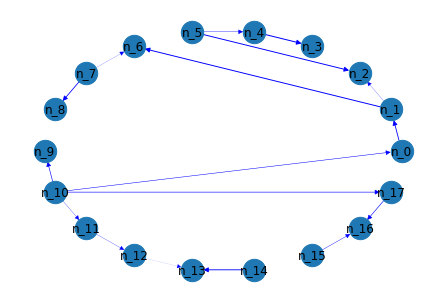

In [3]:
cg.generate_random_graph(mediators=2, forks=2, colliders=2)
cg.show_graph()

## Lets generate few observations for this random causal graph

In [4]:
observations = cg.get_observation(n=800)
print(observations.head())

        n_0       n_1       n_2       n_3       n_4       n_5       n_6  \
0 -0.389075 -0.035317  0.612290 -1.713376 -0.671509  0.484997 -0.196801   
1 -2.201637 -2.256165  1.842958 -2.456066 -0.750646  3.206841 -4.128718   
2  0.237327  0.615179  2.582782 -0.384451  1.172173  2.046652 -0.585633   
3  1.538191  0.124644  1.204945 -1.497591 -0.309621  1.335762 -2.308286   
4 -0.234584 -1.547763 -1.432577  0.618078  1.335713  0.812282 -4.904876   

        n_7       n_8       n_9      n_10      n_11      n_12      n_13  \
0 -1.828431 -2.346335 -1.244652 -2.039087 -2.916042 -2.065345 -2.815871   
1 -0.350071 -0.487725 -1.039972 -1.183005 -2.653455 -0.739218 -1.214083   
2  0.369799 -0.199884 -2.100137 -0.749752  1.109755 -1.864601 -2.504777   
3 -0.777459 -1.255720  0.446182  0.902161 -1.499239 -2.045679 -1.748300   
4 -0.950695 -1.063553 -1.692407 -1.005028  0.650996 -0.685143 -0.247728   

       n_14      n_15      n_16      n_17  
0  0.279640 -1.051224  2.508577  0.404113  
1  2.48914

## Lets take a look at variables which show no linearity

<AxesSubplot:xlabel='n_5', ylabel='n_13'>

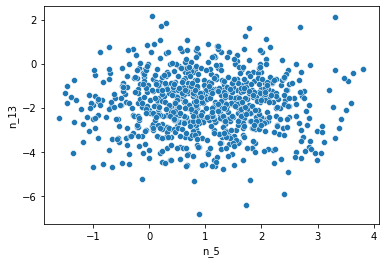

In [6]:
sns.scatterplot(x=observations.n_5, y=observations.n_13)

## Lets also take a look at variables which show linearity

<AxesSubplot:xlabel='n_5', ylabel='n_2'>

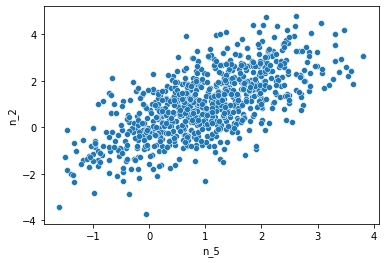

In [7]:
sns.scatterplot(x=observations.n_5, y=observations.n_2)

## Lets compute the Pearson correlation and visulize graph properties

<AxesSubplot:>

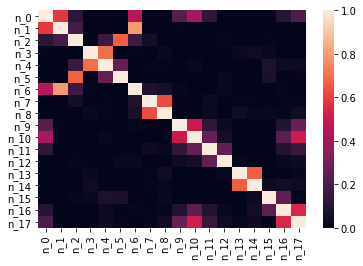

In [8]:
corr_matrix = compute_correlation_between_nodes(cg, observations)
sns.heatmap(corr_matrix, vmin=0, vmax=1)

## Partial correlation

Just like correlation between two variables partial correlation measures linearity between two variables. But if there is a confounder showing association between two varibles then we cannot use regular pearson correlation. We need to measure association with respect to the confounder. A simple way to compute the sample partial correlation for some data is to solve the two associated linear regression problems, get the residuals, and calculate the correlation between the residuals.

In the following section we can see its implemetation and also a standard python package to accomplish this.

In [13]:
import pingouin as pg

def partial_correlation(df):
    from sklearn.linear_model import LinearRegression
    from scipy.stats import pearsonr

    def _standardize(_array):
        _array = np.asarray(_array)
        _mean = np.mean(_array)
        _std = np.std(_array)
        return np.reshape((_array-_mean)/_std, (-1, 1))

    # standardize
    x = _standardize(df.x)
    y = _standardize(df.y)
    z = _standardize(df.z)

    def plot_regression(_reg):
        plot_z = np.reshape(_reg.predict(x), (-1, ))
        # plot input data
        plt.scatter(x.flatten(), z.flatten(),  color='black')
        # plot fitted line
        plt.plot(x.flatten(), plot_z, color='blue', linewidth=3)

    def regress_and_get_residuals(_input, target):
        logging.info(f'Performing linear regression')
        reg = LinearRegression().fit(_input, target)
        logging.info(f'Computing residuals for x and target')
        predictions = np.reshape(reg.predict(_input), (-1, 1))
        residuals = np.subtract(target, predictions).flatten()
        return residuals

    residuals_x_z = regress_and_get_residuals(_input=z, target=x)
    residuals_y_z = regress_and_get_residuals(_input=z, target=y)

    # calculate pearson coefficient
    coeff, _ = pearsonr(residuals_x_z, residuals_y_z)
    result = pd.DataFrame({'n': [len(residuals_x_z)], 'r': [coeff]})
    print(result)
    return result

print("Partial correlation between n_5 and n_13 conditioned on n_7")
df = pd.DataFrame({'x': observations.n_5, 'y': observations.n_13, 'z': observations.n_7})
pg.partial_corr(data=df, x='x', y='y', covar='z').round(3)

Partial correlation between n_5 and n_13 conditioned on n_7


,n,r,CI95%,p-val
pearson,800,-0.014,"[-0.08, 0.06]",0.695


In [14]:
print("Partial correlation between n_14 and n_13 conditioned on n_15")
df = pd.DataFrame({'x': observations.n_14, 'y': observations.n_13, 'z': observations.n_15})
pg.partial_corr(data=df, x='x', y='y', covar='z').round(3)

Partial correlation between n_14 and n_13 conditioned on n_15


,n,r,CI95%,p-val
pearson,800,0.665,"[0.62, 0.7]",0.0


## Plan

As for next steps

1. Understand the CI tests for unit graphs and extend it to ground truth graphs.
2. Extend unit causal graph as time series graph.
3. Implement PC Algorithm 
4. Use Tigramite package to extract causal graphs from spring particle system.
5. ..
6. ..